In [1]:
pip install haversine

In [2]:
import pandas as pd
import numpy as np
from google.colab import files
import os
import haversine as hs
from haversine import Unit
import traceback

#### Open ver3 files

In [3]:
df = pd.read_excel('https://drive.google.com/uc?id=1pk6EAUCmvrMiE-v1ZApTsBQG2STdOstH', header=0)
df = df.sort_values(by=['fih_date1'],ignore_index=True)

In [4]:
df['climate_LAT']=np.nan
df['climate_LON']=np.nan
df['rain_fall_mm']=np.nan
df['max_temperature_c']=np.nan
df['min_temperature_c']=np.nan
df['vp_9am_hpa']=np.nan
df['vp_3pm_hpa']=np.nan
df['dis_latlon_n_climatelatlon']=np.nan

### Process Climate Data
http://www.bom.gov.au/climate/maps/rainfall/?variable=rainfall&map=totals&period=daily&region=nat&year=2020&month=12&day=31

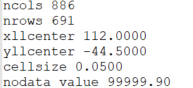

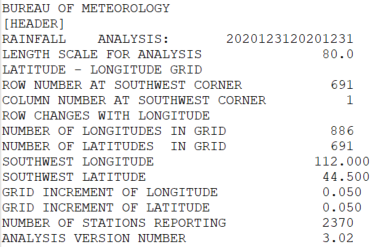

In [5]:
#Make lat lon grid using above information
lat=np.zeros((691,886))
lon=np.zeros((691,886))
for r in np.arange(0,691):
  for c in np.arange(0,886):
    lat[r][c]=-44.5+690*0.05-(r*.05)
    lon[r][c]=112.000+(c*0.05)

In [ ]:
date=''
for index, row in df.iterrows():
  newdate=row['fih_date1'].strftime('%Y%m%d')
  if newdate!=date:
    print("Downloading files for the date : "+newdate)
    date=newdate
    #New date so we should download data for the new date
    #clear all variables
    rainfall=np.nan
    maxtemp=np.nan
    mintemp=np.nan
    vp9am=np.nan
    vp3pm=np.nan
    #1. Rain fall data
    try:
      fn='rainfall.grid'
      r1=os.system('wget -O "'+fn+'.Z" "http://www.bom.gov.au/web03/ncc/www/awap/rainfall/totals/daily/grid/0.05/history/nat/'+date+date+'.grid.Z"')
      if r1==0:
        r2=os.system('uncompress '+fn+'.Z')
        if r2==0:
          r3=os.system("grep '^ ' "+fn+" | sed 's/^ //' > "+date+fn)
          if r3==0:
            rainfall=np.genfromtxt(date+fn, delimiter=' ')
      os.remove(fn)
      os.remove(date+fn)
    except Exception as e:
      print("Rainfall data :"+str(e))
      print(traceback.format_exc())
    #2. Max Temperature
    try:
      fn='maxtemp.grid'
      r1=os.system('wget -O "'+fn+'.Z" "http://www.bom.gov.au/web03/ncc/www/awap/temperature/maxave/daily/grid/0.05/history/nat/'+date+date+'.grid.Z"')
      if r1==0:
        r2=os.system('uncompress '+fn+'.Z')
        if r2==0:
          r3=os.system("grep '^ ' "+fn+" | sed 's/^ //' > "+date+fn)
          if r3==0:
            maxtemp=np.genfromtxt(date+fn, delimiter=' ')
      os.remove(fn)
      os.remove(date+fn)
    except Exception as e:
      print("Max Temperature data :"+str(e))
      print(traceback.format_exc())
    #3. Min Temperature
    try:
      fn='mintemp.grid'
      r1=os.system('wget -O "'+fn+'.Z" "http://www.bom.gov.au/web03/ncc/www/awap/temperature/minave/daily/grid/0.05/history/nat/'+date+date+'.grid.Z"')
      if r1==0:
        r2=os.system('uncompress '+fn+'.Z')
        if r2==0:
          r3=os.system("grep '^ ' "+fn+" | sed 's/^ //' > "+date+fn)
          if r3==0:
            mintemp=np.genfromtxt(date+fn, delimiter=' ')
      os.remove(fn)
      os.remove(date+fn)
    except Exception as e:
      print("Min Temperature data :"+str(e))
      print(traceback.format_exc())
    #4. 9am Vapour Pressure
    try:
      fn='vp9am.grid'
      r1=os.system('wget -O "'+fn+'.Z" "http://www.bom.gov.au/web03/ncc/www/awap/vprp/vprph09/daily/grid/0.05/history/nat/'+date+date+'.grid.Z"')
      if r1==0:
        r2=os.system('uncompress '+fn+'.Z')
        if r2==0:
          r3=os.system("grep '^ ' "+fn+" | sed 's/^ //' > "+date+fn)
          if r3==0:
            vp9am=np.genfromtxt(date+fn, delimiter=' ')
      os.remove(fn)
      os.remove(date+fn)
    except Exception as e:
      print("9am Vapour Pressure data :"+str(e))
      print(traceback.format_exc())
    #5. 3pm Vaour Pressure
    try:
      fn='vp3pm.grid'
      r1=os.system('wget -O "'+fn+'.Z" "http://www.bom.gov.au/web03/ncc/www/awap/vprp/vprph15/daily/grid/0.05/history/nat/'+date+date+'.grid.Z"')
      if r1==0:
        r2=os.system('uncompress '+fn+'.Z')
        if r2==0:
          r3=os.system("grep '^ ' "+fn+" | sed 's/^ //' > "+date+fn)
          if r3==0:
            vp3pm=np.genfromtxt(date+fn, delimiter=' ')
      os.remove(fn)
      os.remove(date+fn)
    except Exception as e:
      print("3pm Vapour Pressure data :"+str(e))
      print(traceback.format_exc())
  #if newdate!=date: ENDS here
  #Get Lat lon Array index of min distance with cliemate grid lat lon
  diff = abs(lat - row['LAT']) + abs(lon - row['LON'])
  idx = np.unravel_index(diff.argmin(), diff.shape)
  try:
    print("Assining Values : "+date)
    df.at[index, 'climate_LAT']=lat[idx[0]][idx[1]]
    df.at[index, 'climate_LON']=lon[idx[0]][idx[1]]
    df.at[index, 'dis_latlon_n_climatelatlon']=hs.haversine((row['LAT'],row['LON']),(lat[idx[0]][idx[1]],lon[idx[0]][idx[1]]),unit=Unit.METERS)
    try:
      if rainfall[idx[0]][idx[1]]!=99999.90: #This is no data default value
        df.at[index, 'rain_fall_mm']=rainfall[idx[0]][idx[1]]
    except:
      pass
    try:
      if maxtemp[idx[0]][idx[1]]!=-99.9900: #This is no data default value
        df.at[index, 'max_temperature_c']=maxtemp[idx[0]][idx[1]]
    except:
      pass
    try:
      if mintemp[idx[0]][idx[1]]!=-99.9900: #This is no data default value
        df.at[index, 'min_temperature_c']=mintemp[idx[0]][idx[1]]
    except:
      pass
    try:
      if vp9am[idx[0]][idx[1]]!=99999.90: #This is no data default value
        df.at[index, 'vp_9am_hpa']=vp9am[idx[0]][idx[1]]
    except:
      pass
    try:
      if vp3pm[idx[0]][idx[1]]!=99999.90: #This is no data default value
        df.at[index, 'vp_3pm_hpa']=vp3pm[idx[0]][idx[1]]
    except:
      pass
  except Exception as e:
    print(df.loc[[index]])
    print("Assiginig data :"+str(e))
    print(traceback.format_exc())

Streaming output truncated to the last 5000 lines.
    Line #1220 (got 9 columns instead of 886)
    Line #1221 (got 134 columns instead of 886)
    Line #1222 (got 148 columns instead of 886)
    Line #1224 (got 742 columns instead of 886)
    Line #1225 (got 34 columns instead of 886)
    Line #1226 (got 110 columns instead of 886)
    Line #1227 (got 531 columns instead of 886)
    Line #1228 (got 355 columns instead of 886)
    Line #1229 (got 748 columns instead of 886)
    Line #1230 (got 24 columns instead of 886)
    Line #1231 (got 114 columns instead of 886)
    Line #1233 (got 755 columns instead of 886)
    Line #1234 (got 139 columns instead of 886)
    Line #1235 (got 758 columns instead of 886)
    Line #1236 (got 7 columns instead of 886)
    Line #1237 (got 1 columns instead of 886)
    Line #1238 (got 1 columns instead of 886)
    Line #1239 (got 1 columns instead of 886)
    Line #1240 (got 118 columns instead of 886)
    Line #1241 (got 542 columns instead of 886)
 

In [ ]:
df.to_excel('WesternAustraliaFireData-ver4.xlsx',index=False)
files.download("/content/WesternAustraliaFireData-ver4.xlsx")